# Modelisation

In [3]:
%load_ext autoreload
%autoreload 2

import warnings
import pandas as pd
from sklearn import set_config

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 5000)
pd.set_option("display.max_rows", 101)
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

set_config(transform_output="pandas")

In [72]:
# Load the data
from sklearn.model_selection import train_test_split

from utils import RANDOM_STATE, TARGET, TEST_SIZE


X = pd.read_csv("./data/kaggle_train_set.csv")

# Supprimons les outliers
large_property_index = X[(X.GrLivArea > 4500) | (X.LotArea >150_000)].index.to_list()
X.drop(index=large_property_index, inplace=True)

y = X.pop(TARGET)

print()
print(f"La shape de X est {X.shape}")
print(f"La shape de y est {y.shape}")



# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
#     )

# print(f"Le train set contient: {X_train.shape} élements")
# print(f"Le test set contient: {X_test.shape} élements")


La shape de X est (1175, 15)
La shape de y est (1175,)


In [73]:
from sklearn.preprocessing import PowerTransformer


target_transformer = PowerTransformer(method='box-cox', )

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, OrdinalEncoder

neighboors_categories = ['MeadowV', 'IDOTRR', 'BrDale', 'Edwards', 'BrkSide', 'OldTown', 'Blueste', 'Sawyer', 'SWISU', 'NAmes', 'NPkVill', 'Mitchel', 'SawyerW', 'Gilbert', 'Blmngtn', 'NWAmes', 'CollgCr', 'ClearCr', 'Crawfor', 'Somerst', 'Timber', 'Veenker', 'StoneBr', 'NoRidge', 'NridgHt']
quality_order = ['Fa', 'TA', 'Gd', 'Ex']

first_stage = ColumnTransformer(
    transformers=[
        ('encoder', OrdinalEncoder(categories=[neighboors_categories, quality_order, quality_order]), ['Neighborhood', 'ExterQual', 'KitchenQual']),
        ('power_transformation', PowerTransformer(method='yeo-johnson'), ['GarageCars', 'GrLivArea', '1stFlrSF']),
        ('nothing', 'passthrough', ['OverallQual', 'YearBuilt'])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

preprocessing = Pipeline(steps=[
    ('first_stage', first_stage),
    ('scaler', StandardScaler())
])

preprocessing

,steps,"[('first_stage', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...), ('power_transformation', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [75]:
preprocessing.fit_transform(X)

,Neighborhood,ExterQual,KitchenQual,GarageCars,GrLivArea,1stFlrSF,OverallQual,YearBuilt
0,0.64,1.07,0.74,0.30,0.55,-0.79,0.66,1.08
1,1.42,-0.68,-0.75,0.30,-0.36,0.43,-0.06,0.18
2,0.64,1.07,0.74,0.30,0.68,-0.56,0.66,1.01
3,1.11,1.07,0.74,0.30,0.52,1.35,1.39,1.11
4,-1.07,-0.68,-0.75,0.30,0.66,-0.23,0.66,-1.32
...,...,...,...,...,...,...,...,...
1175,-1.38,-0.68,-0.75,0.30,-0.84,-0.08,-0.79,1.14
1176,1.11,1.07,0.74,0.30,-0.46,0.33,0.66,1.11
1177,0.18,-0.68,-0.75,0.30,0.44,-0.45,-0.06,0.94
1178,0.95,2.82,0.74,-1.02,1.50,0.24,0.66,-0.99


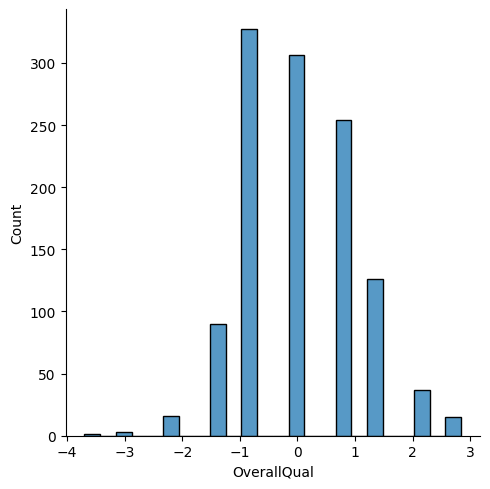

In [76]:
import seaborn as sns

sns.displot(preprocessing.fit_transform(X), x='OverallQual')

In [77]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

models = {
    "Ridge": Ridge(random_state=RANDOM_STATE),
    "Random Forest": RandomForestRegressor(random_state=RANDOM_STATE),
    "Gradient Boosting": GradientBoostingRegressor(loss='huber', random_state=RANDOM_STATE),
    "LGBM": LGBMRegressor(verbose=0, random_state=RANDOM_STATE),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing),
        ('regressor', model)
    ])
    
    # Validation croisée pour calculer la MAE
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
    results[name] = -scores.mean()


print("Résultats des modèles :")
for name, score in results.items():
    print(f"{name}: MAE = {score:.2f}")

Résultats des modèles :
Ridge: MAE = 24254.67
Random Forest: MAE = 19072.72
Gradient Boosting: MAE = 18129.03
LGBM: MAE = 19409.10
SVR: MAE = 55673.42
KNN: MAE = 20828.76


Gradient Boosting performe mieux que les autres. Gardons le pour la suite.

In [78]:
import optuna


def objective(trial):
    # Définir les hyperparamètres à optimiser
    gb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        loss=trial.suggest_categorical("loss", ['squared_error', 'absolute_error', 'huber', 'quantile']),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 100, 1000),
        subsample=trial.suggest_float("subsample", 0.5, 1.0),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 20),
        max_features=trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    )
    
    # Créer le pipeline avec le modèle et le prétraitement
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing),
        ('regressor', GradientBoostingRegressor(random_state=RANDOM_STATE, **gb_params))
    ])
    
    # Validation croisée pour calculer la MAE
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
    return -scores.mean()

# Lancer l'optimisation avec Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Afficher les meilleurs paramètres
best_params = study.best_params
print("Meilleurs hyperparamètres :", best_params)
print("Meilleurs scores: ", study.best_value)

[I 2025-08-26 21:53:20,859] A new study created in memory with name: no-name-2de16e06-5c06-4248-a26e-648837841680


[I 2025-08-26 21:53:35,422] Trial 0 finished with value: 35431.52419069399 and parameters: {'max_depth': 7, 'loss': 'absolute_error', 'learning_rate': 0.0006767547478002392, 'n_estimators': 978, 'subsample': 0.9973472569773674, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 35431.52419069399.
[I 2025-08-26 21:53:37,900] Trial 1 finished with value: 17903.22910187591 and parameters: {'max_depth': 4, 'loss': 'huber', 'learning_rate': 0.04088648108901117, 'n_estimators': 337, 'subsample': 0.7185730774405004, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 1 with value: 17903.22910187591.
[I 2025-08-26 21:53:40,578] Trial 2 finished with value: 17944.420562983847 and parameters: {'max_depth': 2, 'loss': 'huber', 'learning_rate': 0.03466979136175057, 'n_estimators': 719, 'subsample': 0.8621567320523853, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 

Meilleurs hyperparamètres : {'max_depth': 5, 'loss': 'huber', 'learning_rate': 0.015996481097870868, 'n_estimators': 385, 'subsample': 0.7656864272872252, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}
Meilleurs scores:  17663.07668043563


In [80]:
# Entrainement sur l´ensemble du dataset
from sklearn.metrics import make_scorer
from sklearn.model_selection import TunedThresholdClassifierCV

best_params = {'max_depth': 5, 'loss': 'huber', 'learning_rate': 0.015996481097870868, 'n_estimators': 385, 'subsample': 0.7656864272872252, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}

estimator = Pipeline(
    steps=[
        ('preprocessing', preprocessing),
        ('regressor', GradientBoostingRegressor(random_state=RANDOM_STATE, **best_params))
        ]
)

estimator.fit(X, y)

# Load the data
test = pd.read_csv("./data/kaggle_test_set.csv")

# Prédictions
result = estimator.predict(test)

# Créer le DataFrame de soumission avec "ID" comme index
submission_df = pd.DataFrame(result, columns=["SalePrice"], index=test.index)
submission_df.index.name = "ID"  # Renommer l'index en "ID"

# Sauvegarder le fichier CSV
submission_df.to_csv("./data/submission.csv")

# Vérification
check_df = pd.read_csv("./data/submission.csv", index_col='ID')
check_df.head()

,SalePrice
ID,
0,178953.19
1,357756.75
2,190461.63
3,156117.14
4,115669.87


In [ ]:
from datetime import datetime
import io
import subprocess
import time

from utils import sauvegarder_model

competition = "regression-prediction-prix-immobilier"


def all_status_complete(df):
    return all(df['status'].isin(['SubmissionStatus.ERROR', 'SubmissionStatus.COMPLETE']))

# Fonction pour relancer le subprocess et récupérer les données
def relaunch_subprocess():
    result = subprocess.run(
        ["kaggle", "competitions", "submissions", "-v", "-c",  competition],
        capture_output=True,
        text=True
        )
    return result.stdout



now = str(datetime.now())
# Timeout de 1 minute
timeout = 60  # en secondes
start_time = time.time()

data = None

if SUBMIT:= True:
    file_path = "./data/submission.csv"
    message = f"timestamp: {now}, Utilisation des paramètres: {estimator.get_params()}"

    result = subprocess.run(
        ["kaggle", "competitions", "submit", "-c", competition, "-f", file_path, "-m", message],
        capture_output=True,
        text=True
    )

    print("⚒️", result.stdout)

    if result.stderr != '':
        print(result.stderr)
    data = None

    while True:
        # Récupérer les données depuis le subprocess
        stdout_data = relaunch_subprocess()
        
        # Convertir les données en DataFrame
        data = pd.read_csv(io.StringIO(stdout_data), parse_dates=['date'])
        
        # Vérifier si tous les statuts sont complets
        if all_status_complete(data):
            break
        
        # Vérification du timeout
        if time.time() - start_time > timeout:
            print("")
            raise RuntimeError("imeout atteint. Arrêt de la boucle.")
        
        # Pause avant la prochaine vérification
        time.sleep(20)  # Pause de 20 secondes

    if data is not None and all_status_complete(data):
        # Trouver la ligne avec la date la plus récente
        most_recent = data.sort_values('date', ascending=False).iloc[0]
        recent_score = most_recent['publicScore']
        best_score = data['publicScore'].min()

        if recent_score < best_score:
            print(f"🥳 Nouveau meilleur score : {recent_score:.5f}")
            sauvegarder_model(estimator, timestamp=now, only_latest=False)
        else:
            print(f"❌ Bien essayé mais c´est moins bon. Score: {recent_score:.5f}. Meilleur score : {best_score:.5f}")

if not SUBMIT:
    sauvegarder_model(estimator, timestamp=now, only_latest=True)


⚒️ Successfully submitted to Régression prédiction prix immobilier

  0%|          | 0.00/6.09k [00:00<?, ?B/s]
100%|██████████| 6.09k/6.09k [00:00<00:00, 13.8kB/s]

❌ Bien essayé mais c´est moins bon. Score: 18390.22768. Meilleur score : 18390.22768
